# Dynamic Derivatives Using Sliding Interfaces

This notebook demonstrates how to obtain **dynamic stability derivatives** by simulating unsteady flow over a NACA0012 wing that pitches back and forth within a **sliding interface**.

### Geometry
The wing geometry has:
- **Chord** $c$ = 1 m
- **Span** $b$ = 2 m  
- **Reference area** $A_{ref}$ = 2 m²
- **Moment length** = [$b$/2, $c$, $b$/2] = [1, 1, 1] m
- **Moment center** = [0, 0, 0] (at quarter-chord, midspan)


### Simulation Strategy
**Steady Initialization:**
- Ramp CFL from 1 to 100 over 1000 steps for robust convergence
- Fixed sliding interface (zero angular velocity) to establish baseline flow
- Maximum 10000 steps to ensure convergence

**Unsteady Oscillation:**
- Sliding interface updated to oscillating motion
- Sinusoidal pitching with amplitude 2° and frequency 2.5 flowthru/rad
- 400 time steps (4 complete cycles)

## 1. Download tutorial files

In [1]:
import math
import flow360 as fl
from flow360.examples import TutorialDynamicDerivatives

TutorialDynamicDerivatives.get_files()

The downloaded files include the geometry (CSM format) for the NACA0012 wing.

## 2. Create project from geometry

In [2]:
project = fl.Project.from_geometry(
    TutorialDynamicDerivatives.geometry,
    name="Tutorial Calculating Dynamic Derivatives using Sliding Interfaces from Python",
)
geometry = project.geometry
geometry.group_faces_by_tag("faceName")

Output()

[09:57:06] INFO: Geometry successfully submitted:                                                                  
                   type        = Geometry                                                                          
                   name        = Tutorial Calculating Dynamic Derivatives using Sliding Interfaces from Python     
                   id          = geo-e863d8e0-f3b6-4dd9-ba79-ff8cb38d3272                                          
                   status      = uploaded                                                                          
                   project id  = prj-9f2dbc33-dc46-4fa8-a385-82b4f61cc317                                          
           

           INFO: Waiting for geometry to be processed.

Output()

The wing is enclosed in a cylindrical sliding interface as shown below:

![Wing in Sliding Interface](figures/wingInSlidingInterface.png)

*Figure: Wing enclosed in cylindrical sliding interface. The interface rotates about the y-axis, causing the wing to pitch.*

## 3. Define sliding interface and meshing parameters

The wing is enclosed in a cylindrical sliding interface:
- **Radius** = 1.0 m
- **Height** = 2.5 m
- **Rotation center** = [0, 0, 0]
- **Rotation axis** = y-axis [0, 1, 0]

In [3]:
with fl.SI_unit_system:
    cylinder = fl.Cylinder(
        name="cylinder",
        axis=[0, 1, 0],
        center=[0, 0, 0],
        inner_radius=0,
        outer_radius=1.0,
        height=2.5,
    )
    sliding_interface = fl.RotationVolume(
        spacing_axial=0.04,
        spacing_radial=0.04,
        spacing_circumferential=0.04,
        entities=cylinder,
        enclosed_entities=geometry["wing"],
    )
    farfield = fl.AutomatedFarfield(name="farfield")

[09:57:33] INFO: using: SI unit system for unit inference.

Key meshing parameters:
- Automated meshing with sliding interface and farfield zones
- Refined leading and trailing edges for accuracy
- Boundary layer resolved with first layer thickness of 1e-6 m

In [4]:
with fl.SI_unit_system:
    meshing_params = fl.MeshingParams(
        defaults=fl.MeshingDefaults(
            surface_max_edge_length=0.03 * fl.u.m,
            curvature_resolution_angle=8 * fl.u.deg,
            surface_edge_growth_rate=1.15,
            boundary_layer_first_layer_thickness=1e-6,
            boundary_layer_growth_rate=1.15,
        ),
        refinement_factor=1.0,
        volume_zones=[sliding_interface, farfield],
        refinements=[
            fl.SurfaceEdgeRefinement(
                name="leadingEdge",
                method=fl.AngleBasedRefinement(value=1 * fl.u.degree),
                edges=geometry["leadingEdge"],
            ),
            fl.SurfaceEdgeRefinement(
                name="trailingEdge",
                method=fl.HeightBasedRefinement(value=0.001),
                edges=geometry["trailingEdge"],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

## 4. Run steady case to initialize the flow field

First, we run a steady case with a fixed sliding interface (zero angular velocity) to initialize the flow field. This provides a converged solution to start the unsteady simulation.

In [5]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing_params,
        reference_geometry=fl.ReferenceGeometry(
            moment_center=[0, 0, 0],
            moment_length=[1, 1, 1],
            area=2,
        ),
        operating_condition=fl.AerospaceCondition(
            velocity_magnitude=50,
        ),
        time_stepping=fl.Steady(
            max_steps=10000,
            CFL=fl.RampCFL(initial=1, final=100, ramp_steps=1000),
        ),
        outputs=[
            fl.VolumeOutput(name="VolumeOutput", output_fields=["Mach"]),
            fl.SurfaceOutput(
                name="SurfaceOutput",
                surfaces=geometry["*"],
                output_fields=["Cp", "CfVec"],
            ),
        ],
        models=[
            fl.Rotation(
                volumes=cylinder,
                spec=fl.AngularVelocity(0 * fl.u.rad / fl.u.s),
            ),
            fl.Freestream(surfaces=farfield.farfield, name="Freestream"),
            fl.Wall(surfaces=geometry["wing"], name="NoSlipWall"),
            fl.Fluid(
                navier_stokes_solver=fl.NavierStokesSolver(
                    absolute_tolerance=1e-9,
                    linear_solver=fl.LinearSolver(max_iterations=35),
                ),
                turbulence_model_solver=fl.SpalartAllmaras(
                    absolute_tolerance=1e-8,
                    linear_solver=fl.LinearSolver(max_iterations=25),
                ),
            ),
        ],
    )

project.run_case(
    params=params, name="Tutorial Dynamic Derivatives - Steady Initialization"
)

steady_case = fl.Case.from_cloud(project.case.id)

           INFO: using: SI unit system for unit inference.

           INFO: using: SI unit system for unit inference.

[09:57:36] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Tutorial Dynamic Derivatives - Steady Initialization                              
                   id          = case-fc35883b-74e5-4ac9-9697-17e0a3e6a1bc                                         
                   status      = pending                                                                           
                   project id  = prj-9f2dbc33-dc46-4fa8-a385-82b4f61cc317                                          
           

## 5. Understanding the Oscillation Setup

The sliding interface oscillates according to the angle expression:

$$\theta = A \sin(\omega_\text{non-dim} \cdot t_\text{non-dim})$$

Where:
- $A$ = 0.0349066 rad (equivalent to 2°) - amplitude of oscillation
- $\omega_\text{non-dim}$ = nondimensional angular frequency
- $t_\text{non-dim}$ = nondimensional time

**Calculating the nondimensional frequency:**

We want the wing to complete one oscillation cycle over a specific number of flowthroughs. In this example, we use $n$ = 2.5 flowthru/rad, meaning when $\omega \cdot t$ changes by 1 radian, the air flows through 2.5 chord lengths.

Given:
- Freestream velocity $U_\infty$ = 50 m/s
- Chord $c$ = 1 m
- Speed of sound $C_\infty$ = 340.294 m/s
- Grid unit $L_\text{gridUnit}$ = 1 m

Physical angular frequency:
$$\omega_{physical} = \frac{U_\infty}{n \cdot c} = \frac{50}{2.5 \times 1} = 20 \text{ rad/s}$$

Nondimensional angular frequency:
$$\omega = \frac{\omega_{physical}}{C_\infty / L_{gridUnit}} = \frac{20}{340.294} \approx 0.05877271$$

**Time step size:**

We split each oscillation period into 100 steps:
$$\Delta t = 0.01 \cdot \frac{2\pi}{\omega} \approx 0.01 \cdot \frac{2\pi}{0.05877271}$$

## 6. Run unsteady case with oscillating interface

Now we update the simulation parameters for the unsteady case and fork from the steady solution. Only the time stepping and rotation spec need to be modified.

In [6]:
# Update parameters for unsteady case
with fl.SI_unit_system:
    params.time_stepping = fl.Unsteady(
        max_pseudo_steps=80,
        steps=400,
        step_size=0.01 * 2.0 * math.pi / 20.0 * fl.u.s,
        CFL=fl.RampCFL(initial=1, final=1e8, ramp_steps=20),
    )
    params.models[0].spec = fl.AngleExpression("0.0349066 * sin(0.05877271 * t)")

# Run unsteady case forked from steady solution
project.run_case(
    params=params,
    name="Tutorial Dynamic Derivatives - Unsteady Oscillation",
    fork_from=steady_case,
)
unsteady_case = project.case

           INFO: using: SI unit system for unit inference.

           INFO: using: SI unit system for unit inference.

Output()

[09:57:37] INFO: using: SI unit system for unit inference.

[09:57:38] INFO: Successfully submitted:                                                                           
                   type        = Case                                                                              
                   name        = Tutorial Dynamic Derivatives - Unsteady Oscillation                               
                   id          = case-e040a828-b521-432a-8402-5e1c58dcb612                                         
                   status      = pending                                                                           
                   project id  = prj-9f2dbc33-dc46-4fa8-a385-82b4f61cc317                                          
           

## 7. Postprocessing - Extract Dynamic Derivatives

Once the simulation is complete, we download the results and calculate the dynamic derivatives. The key output is the `total_forces` data which contains force and moment coefficients at each time step.

In [7]:
import flow360 as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cmap = plt.colormaps["tab10"]

# Load completed example case from the example library (flow360 25.8 or above)
project = fl.Project.from_example(by_name="Dynamic Derivatives")
case = project.get_case()

# Note that in this example we're loading a pre-computed unsteady case from the example library,
# so the reader doesn't need to wait for the simulation to finish.
# For production usage, the user can use:
# case = unsteady_case
# or:
# case = fl.Case.from_cloud("your-case-id")

# Download and load results
case.results.total_forces.download(to_file="total_forces.csv")
case.results.total_forces.load_from_local("total_forces.csv")
total_forces = case.results.total_forces.as_dataframe()

           INFO: Found closest match for 'Dynamic Derivatives': 'Calculating Dynamic Derivatives using Sliding     
           Interfaces' (similarity: 50.67 %)

[09:57:39] INFO: Copy operation started for project prj-0ad2a0d2-873f-43cc-b38a-a4e4e7b7268c. Waiting for          
           completion...

Output()

[09:57:51] INFO: Copy operation completed successfully.

Output()

[09:57:53] INFO: Saved to total_forces.csv

### Extract unique physical steps

The `total_forces` data contains multiple rows per physical step (one per pseudo-step). We extract the final converged value at each physical step.

In [8]:
def extract_unique_physical_steps(input_df):
    """Extract the row at the last pseudo step at the end of each physical step."""
    physical_steps_raw = input_df["physical_step"]
    n_rows = len(physical_steps_raw)
    selected_row_index = []
    for i in range(n_rows - 1):
        if physical_steps_raw.iloc[i + 1] > physical_steps_raw.iloc[i]:
            selected_row_index.append(i)
    selected_row_index.append(n_rows - 1)
    output = pd.DataFrame()
    for k, v in input_df.items():
        output[k] = [v.iloc[j] for j in selected_row_index]
    return output.reset_index(drop=True)


total_forces = extract_unique_physical_steps(total_forces)
print(f"Number of physical steps: {len(total_forces)}")

Number of physical steps: 400


### Calculate nondimensional time, angle of attack, and pitch rate

We compute:
- Nondimensional time from physical steps
- Angle of attack $\alpha = A \sin(\omega t)$
- Pitch rate $\dot{\alpha}$ using central differences, converted to rad/flowthru

In [9]:
# Define simulation parameters
length_unit = case.params.private_attribute_asset_cache.project_length_unit  # m
U_inf = case.params.operating_condition.velocity_magnitude  # m/s
C_inf = 340.29400580821283 * fl.u.m / fl.u.s  # speed of sound
n_chord_per_period = 2.5  # flowthru/rad
chord = 1 * fl.u.m

omega_physical = U_inf / (n_chord_per_period * chord)  # 1/s
omega_nondim = omega_physical / (C_inf / length_unit)
time_step_size_nondim = 0.01 * 2 * np.pi / omega_nondim  # nondim

amplitude_deg = 2 * fl.u.deg
amplitude_rad = amplitude_deg.to(fl.u.rad)


def compute_time_nondim(df):
    """Compute nondimensional time from physical step."""
    n_steps = len(df["physical_step"])
    df["time_nondim"] = np.zeros(n_steps)
    for i in range(n_steps):
        df.loc[i, "time_nondim"] = time_step_size_nondim * (
            df.loc[i, "physical_step"] + 1
        )


def compute_alpha_dot(df):
    """Compute angle of attack and pitch rate."""
    n_steps = len(df["physical_step"])
    df["alpha"] = np.zeros(n_steps)
    df["alpha_dot"] = np.zeros(n_steps)
    alpha_eq_0_index = []

    # Compute alpha
    for i in range(n_steps):
        t = df.loc[i, "time_nondim"]
        df.loc[i, "alpha"] = amplitude_rad * np.sin(omega_nondim * t)

    # Compute alpha_dot using central difference
    for i in range(1, n_steps - 1):
        df.loc[i, "alpha_dot"] = (
            (df.loc[i + 1, "alpha"] - df.loc[i - 1, "alpha"])
            / (2 * time_step_size_nondim)
            * C_inf
            / length_unit
            * chord
            / U_inf
        )
        if abs(df.loc[i, "alpha"]) < 1e-10:
            alpha_eq_0_index.append(i)

    return alpha_eq_0_index


compute_time_nondim(total_forces)
alpha_eq_0_index = compute_alpha_dot(total_forces)
print(f"Found {len(alpha_eq_0_index)} points where alpha = 0")

Output()

[09:57:54] INFO: using: SI unit system for unit inference.

Found 7 points where alpha = 0


### Plot time history

Plot the time history of the pitch moment coefficient $C_{My}$, angle of attack $\alpha$, and pitch rate $\dot{\alpha}$. The blue and red dots mark the points where $\alpha = 0$ (extrema of $\dot{\alpha}$).

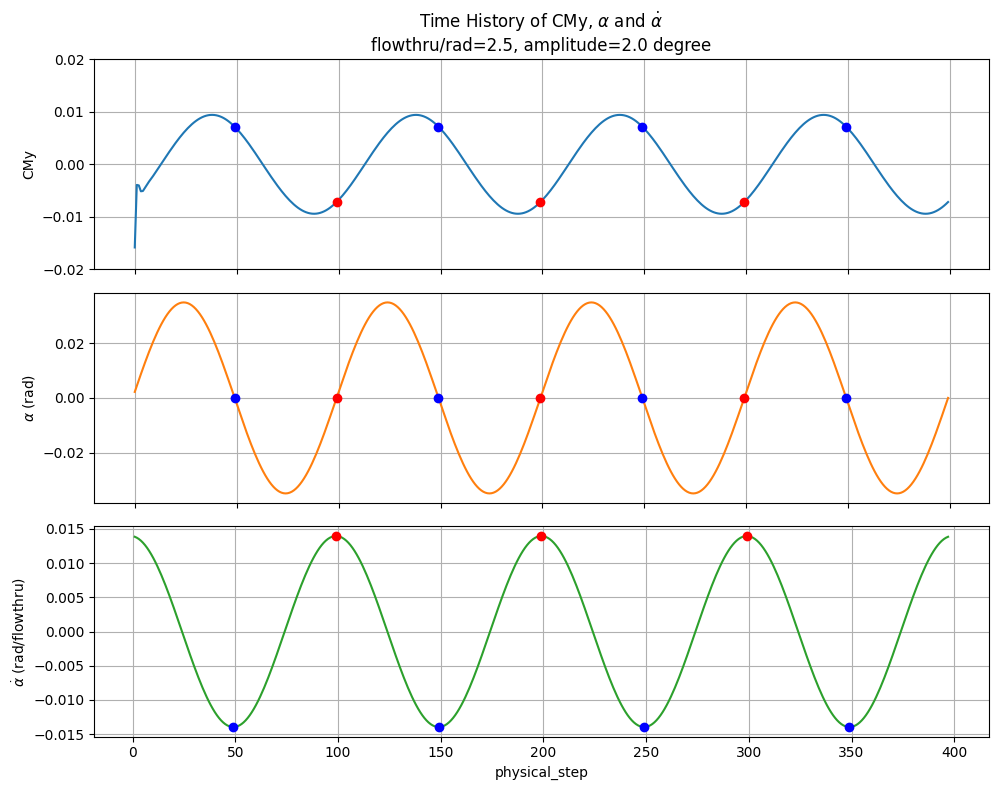

In [10]:
def plot_time_history(df, alpha_eq_0_idx):
    _, axs = plt.subplots(3, figsize=(10, 8))

    # Time history of CMy
    axs[0].plot(df["physical_step"], df["CMy"], color=cmap.colors[0])
    axs[0].set_yticks(np.linspace(-0.02, 0.02, 5))
    axs[0].set_ylim([-0.02, 0.02])
    axs[0].set_ylabel("CMy")

    # Time history of alpha
    axs[1].plot(df["physical_step"], df["alpha"], color=cmap.colors[1])
    axs[1].set_ylabel(r"$\alpha$ (rad)")

    # Time history of alpha_dot
    axs[2].plot(df["physical_step"][1:-2], df["alpha_dot"][1:-2], color=cmap.colors[2])
    axs[2].set_ylabel(r"$\dot{\alpha}$ (rad/flowthru)")
    axs[2].set_xlabel("physical_step")

    for ax in axs:
        ax.label_outer()
        ax.grid()

    # Mark alpha=0 points (blue for min alpha_dot, red for max alpha_dot)
    for i in alpha_eq_0_idx:
        color = "b" if df["alpha_dot"][i] < 0 else "r"
        axs[0].plot(df["physical_step"][i], df["CMy"][i], "o", color=color)
        axs[1].plot(df["physical_step"][i], df["alpha"][i], "o", color=color)
        axs[2].plot(df["physical_step"][i], df["alpha_dot"][i], "o", color=color)

    axs[0].set_title(
        r"Time History of CMy, $\alpha$ and $\dot{\alpha}$"
        + "\n"
        + f"flowthru/rad={n_chord_per_period:.1f}, amplitude={amplitude_deg:.1f}"
    )
    plt.tight_layout()
    plt.show()


plot_time_history(total_forces, alpha_eq_0_index)

### Extract dynamic derivative

Plot $C_{My}$ vs $\dot{\alpha}$ for the last oscillation period and compute the dynamic derivative $\frac{dC_{My}}{dq}$ from linear regression at $\alpha = 0$.

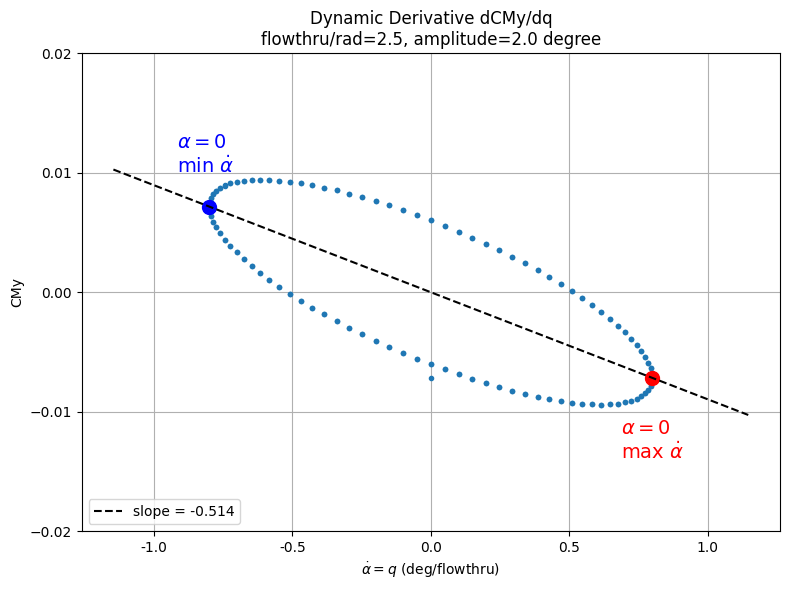


Dynamic derivative: dCMy/dq = -0.514


In [11]:
def plot_CMy_vs_q(df, alpha_eq_0_idx):
    plt.figure(figsize=(8, 6))

    # Plot CMy versus alpha_dot for the last period
    n_steps = len(df["physical_step"])
    begin = n_steps - 201
    end = n_steps - 1
    alpha_dot = df.loc[begin:end, "alpha_dot"]
    CMy = df.loc[begin:end, "CMy"]
    plt.plot(alpha_dot, CMy, ".")

    # Extract alpha=0 points in the last period
    x = []
    y = []
    for i in alpha_eq_0_idx:
        if i >= begin and i <= end:
            x.append(df.loc[i, "alpha_dot"])
            y.append(df.loc[i, "CMy"])

    # Mark the alpha=0 points
    plt.plot(x[0], y[0], "o", color="r", markersize=10)
    plt.plot(x[1], y[1], "o", color="b", markersize=10)

    # Linear regression through alpha=0 points
    coef = np.polyfit(x, y, 1)
    func = np.poly1d(coef)
    x_line = np.linspace(-0.02, 0.02, 101)
    plt.plot(x_line, func(x_line), "--", label=f"slope = {coef[0]:.3f}", color="k")

    # Formatting
    plt.xlabel(r"$\dot{\alpha} = q$ (deg/flowthru)")
    plt.ylabel("CMy")
    plt.ylim([-0.02, 0.02])
    plt.yticks(np.linspace(-0.02, 0.02, 5))
    plt.grid()
    plt.legend(loc="lower left")
    plt.title(
        f"Dynamic Derivative dCMy/dq\nflowthru/rad={n_chord_per_period:.1f}, amplitude={amplitude_deg:.1f}"
    )

    # Set x-axis to deg/flowthru
    tick_locations = np.linspace(-1, 1, 5) / 180 * np.pi
    ax = plt.gca()
    ax.set_xticks(
        tick_locations, [f"{loc * 180 / np.pi:.1f}" for loc in tick_locations]
    )

    # Add text annotations
    ax.text(
        -0.016,
        0.01,
        r"$\alpha = 0$" + "\n" + r"min $\dot{\alpha}$",
        fontsize=14,
        color="b",
    )
    ax.text(
        +0.012,
        -0.014,
        r"$\alpha = 0$" + "\n" + r"max $\dot{\alpha}$",
        fontsize=14,
        color="r",
    )

    plt.tight_layout()
    plt.show()

    print(f"\nDynamic derivative: dCMy/dq = {coef[0]:.3f}")


plot_CMy_vs_q(total_forces, alpha_eq_0_index)

## Summary

This notebook demonstrated the complete workflow for calculating dynamic derivatives using Flow360:

1. **Download Tutorial Files**: Obtained the NACA0012 wing geometry (CSM format)
2. **Create Project**: Set up a Flow360 project from the geometry
3. **Define Sliding Interface and Meshing**: Configured the cylindrical sliding interface enclosing the wing, farfield zone, and mesh refinements
4. **Run Steady Case**: Initialized the flow field with a fixed sliding interface (zero angular velocity)
5. **Understanding Oscillation Setup**: Calculated nondimensional frequency and time step for sinusoidal pitching motion
6. **Run Unsteady Case**: Forked from steady solution and ran 400 time steps (4 complete cycles) with oscillating interface
7. **Postprocessing**: Extracted dynamic derivatives from force history
   - Extracted unique physical steps from force history
   - Computed angle of attack $\alpha$ and pitch rate $\dot{\alpha}$
   - Extracted dynamic derivative from linear fit at $\alpha = 0$

**Key Result**: The dynamic pitching moment derivative is approximately:
$$\frac{dC_{My}}{d\dot{\alpha}} = \frac{dC_{My}}{dq} \approx -0.5$$

This derivative is critical for:
- Flight dynamics modeling
- Stability and control analysis
- Control system design
- Aircraft certification